In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_format = 'retina'

In [4]:
import sys
sys.path.append('../src')

In [5]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import seaborn as sns
import torch
import pandas as pd
import spaceoracle
from spaceoracle import SpaceOracle

2024-10-30 18:05:29.824653: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score

In [7]:
adata_train = sc.read_h5ad('.cache/adata_train.h5ad')
adata_train

AnnData object with n_obs × n_vars = 11567 × 5013
    obs: 'cluster', 'rctd_cluster', 'rctd_celltypes'
    uns: 'log1p'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [8]:
from spaceoracle.models.parallel_estimators import SpatialCellularProgramsEstimator

In [9]:
from spaceoracle.models.pixel_attention import CellularNicheNetwork

In [10]:
from spaceoracle.tools.utils import search

In [11]:
estimator = SpatialCellularProgramsEstimator(
    adata=adata_train,
    target_gene='Pax5',
)

In [12]:
%%time

estimator.fit(num_epochs=1, threshold_lambda=1e-4, learning_rate=1e-3)

Fitting Pax5 with 228 modulators
	59 Transcription Factors
	27 Ligand-Receptor Pairs
	142 TranscriptionFactor-Ligand Pairs
0: 0.4674 | 0.9522
1: -66.5096 | 0.9463
2: -56.8725 | 0.9352
3: -105.3939 | 0.9355
4: -26.5073 | 0.9787
5: -51.5392 | 0.9717
6: -64.4661 | 0.9835
CPU times: user 1min 55s, sys: 39.9 s, total: 2min 35s
Wall time: 4min 22s


In [28]:
df = estimator.betadata

In [29]:
betas = torch.from_numpy(
    df[['beta0']+['beta_'+i for i in estimator.modulators]].values).float()

inputs_x = torch.from_numpy(
    estimator.train_df.drop(
        columns=estimator.target_gene).values).float()

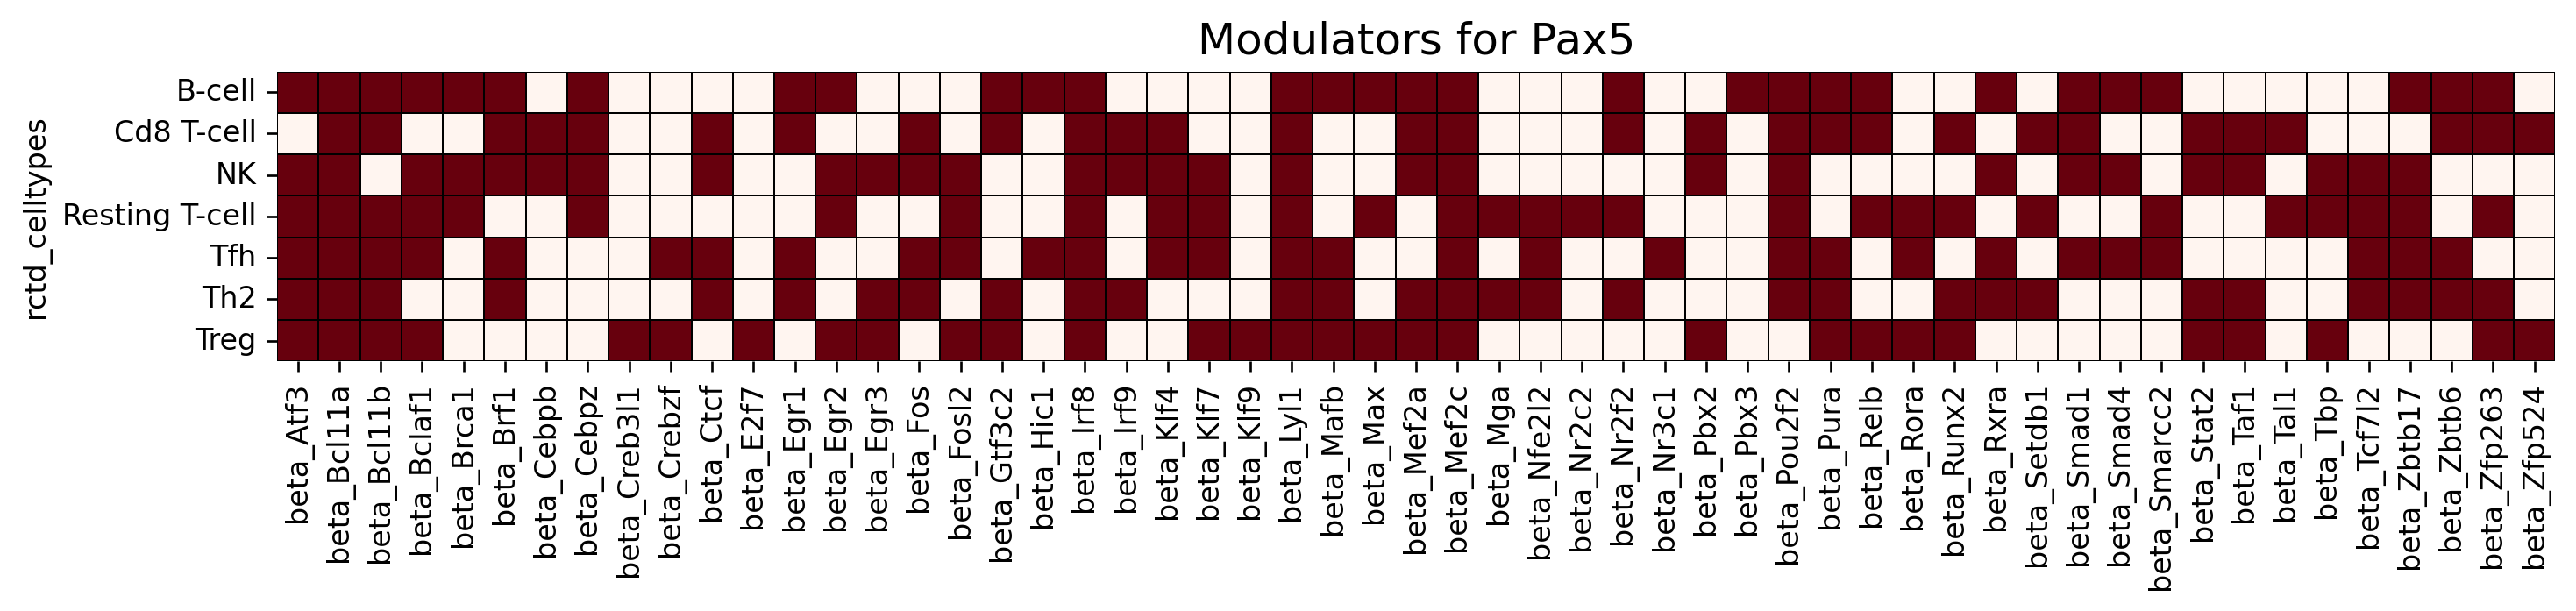

In [30]:
plt.rcParams['figure.figsize'] = (25, 3)
plt.rcParams['figure.dpi'] = 120

hmap = df[[
        'beta_'+i for i in estimator.modulators if '#' not in i and '$' not in i]+[
            'rctd_celltypes']].groupby('rctd_celltypes').mean().abs()>0
sns.heatmap(
    hmap.loc[:, (hmap.sum(0) > 0)],
    square=True,
    cbar=False,
    linewidths=0.5,
    linecolor='black',
    xticklabels=True,
    yticklabels=True,
    cmap='Reds'
)
plt.title(f'Modulators for {estimator.target_gene}', fontsize=15)
plt.tight_layout()
plt.show()

# plt.rcParams['figure.figsize'] = (25, 5)
# hmap = df[[
#         'beta_'+i for i in estimator.modulators if '$' in i]+[
#             'rctd_celltypes']].groupby('rctd_celltypes').mean().abs()>0
# sns.heatmap(
#     hmap.loc[:, (hmap.sum(0) > 0)],
#     square=True,
#     cbar=False,
#     linewidths=0.5,
#     linecolor='black',
#     xticklabels=True,
#     yticklabels=True,
#     cmap='Reds'
# )
# plt.title(f'Modulators for {estimator.target_gene}', fontsize=15)
# plt.tight_layout()
# plt.show()
# hmap = df[[
#         'beta_'+i for i in estimator.modulators if '#' in i]+[
#             'rctd_celltypes']].groupby('rctd_celltypes').mean().abs()>0
# sns.heatmap(
#     hmap.loc[:, (hmap.sum(0) > 0)],
#     square=True,
#     cbar=False,
#     linewidths=0.5,
#     linecolor='black',
#     xticklabels=True,
#     yticklabels=True,
#     cmap='Reds'
# )

# plt.title(f'Modulators for {estimator.target_gene}', fontsize=15)
# plt.tight_layout()
# plt.show()

In [33]:
y_pred = CellularNicheNetwork.predict_y(inputs_x, betas)

r2_score(
    estimator.train_df[estimator.target_gene], 
    y_pred.cpu().numpy()
)

0.04412528965593687

In [20]:
cmaps = dict(zip(range(7), ['rainbow', 'hot', 'cool_r', 'spring', 'viridis', 'PuRd', 'Reds']))


In [21]:
df[['beta0']+['beta_'+i for i in estimator.modulators]].mean().sort_values(ascending=False)[:30]

beta0                      0.342871
beta_Mef2c                 0.113910
beta_Bcl11a                0.073470
beta_Irf8                  0.071184
beta_Lyl1                  0.035351
beta_Pou2f2                0.025278
beta_Cxcl12$Cxcr4          0.024967
beta_Il4$Il4ra             0.022228
beta_Cxcl13$Cxcr5          0.021966
beta_C4b$Cr2               0.018992
beta_Il2#Egr1              0.018973
beta_Tnfsf13b$Tnfrsf13c    0.017844
beta_Il15#Mef2c            0.017501
beta_Il21#Mef2c            0.016652
beta_C3$Cr2                0.014345
beta_Ebi3#Pura             0.013077
beta_Ebi3#Taf1             0.012160
beta_Cebpz                 0.011306
beta_Clcf1#Klf13           0.011016
beta_Smarcc2               0.010974
beta_Nr2f2                 0.010959
beta_Ebi3#Relb             0.010287
beta_Il15#Egr1             0.009754
beta_Il2#Egr2              0.009732
beta_Il21#Pura             0.009720
beta_Bclaf1                0.009113
beta_Il2#Bcl11b            0.009044
beta_Mef2a                 0

In [ ]:
# markers = ['o', 'X', '<', '^', 'v', 'D', '>']
# cmaps = dict(zip(range(7), ['rainbow', 'cool', 'RdYlGn_r', 'spring_r', '', 'PuRd', 'Reds']))
# cell_map = dict(zip(df['rctd_cluster'], df['rctd_celltypes']))

# def plot(plot_for, clusters=[0, 1, 2], with_expr=False, size=25, linewidth=0.5, alpha=1, edgecolor='black', dpi=100, figsize=(11, 9)):

#     fig, (ax, cax) = plt.subplots(1, 2, dpi=dpi, figsize=figsize, gridspec_kw={'width_ratios': [4, 0.5]})

#     for i in clusters:
#         betas_df = df[['beta0']+['beta_'+i for i in np.unique(estimator.modulators+estimator.ligands+estimator.receptors)]][df.rctd_cluster==i]
#         betas_df = betas_df.join(estimator.train_df)

#         if with_expr:
#             betas_df[plot_for] = betas_df[plot_for]*betas_df[plot_for.replace('beta_', '')]

#         sns.scatterplot(
#             data=betas_df.join(df[['x', 'y', 'rctd_celltypes']]),
#             x='x', 
#             y='y',
#             hue=plot_for,
#             palette=cmaps[i],
#             s=size,
#             # alpha=1 if i == 0 else 0.1,
#             alpha=alpha,
#             linewidth=linewidth,
#             edgecolor=edgecolor,
#             legend=False,
#             style='rctd_celltypes',
#             markers=markers,
#             ax=ax
#         )
#     ax.axis('off')

#     norm = None

#     cbar_width = 0.15  # Width of each colorbar
#     cbar_height = 0.8 / len(cmaps)  # Height of each colorbar
#     for i, cmap_name in cmaps.items():
#         if i not in [0, 1, 2]:
#             continue
#         cmap = plt.get_cmap(cmap_name)
#         sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#         sm.set_array([])
#         cax_i = cax.inset_axes([0.2, 0.95 - (i+1)*cbar_height*2.5, cbar_width, cbar_height*1.5])
#         cbar = fig.colorbar(sm, cax=cax_i, orientation='vertical')
#         cbar.ax.tick_params(labelsize=9)  # Reduce tick label size
#         cbar.ax.set_title(f'{cell_map[i]}', fontsize=12, pad=8)  # Reduce title size and padding

#     cax.set_ylabel(plot_for, fontsize=8)
#     cax.axis('off')

#     unique_styles = sorted(set(df['rctd_celltypes']))
#     style_handles = [plt.Line2D([0], [0], marker=m, color='w', markerfacecolor='gray', 
#                     markersize=10, linestyle='None', alpha=1) 
#                     for m in markers][:len(unique_styles)]
#     ax.legend(style_handles, unique_styles, ncol=1,
#         title='Cell types', loc='upper left', 
#         frameon=False)

#     ax.set_title(f'{plot_for} > {estimator.target_gene}', fontsize=15)
    
#     return ax

In [61]:
from spaceoracle.oracles import SpaceOracle

so = SpaceOracle(adata=adata_train)
beta_dict = {'Pax5': so._get_betas('Pax5')}

gex_df = estimator.adata.to_df()
beta_dict = so._get_wbetas_dict(beta_dict, gex_df, n_jobs=1)
wbetas = beta_dict['Pax5'].wbetas


# reformat betas so it's the same as when plot method was written
xy = pd.DataFrame(
    adata_train.obsm['spatial'], index=adata_train.obs.index, columns=['x', 'y'])

df = wbetas \
        .join(adata_train.obs) \
        .join(xy)

df

  0%|          | 0/1 [00:00<?, ?it/s]

,beta_Angptl4,beta_Atf3,beta_Bcl11a,beta_Bcl11b,beta_Bclaf1,beta_Brca1,beta_Brf1,beta_C3,beta_C4b,beta_Cebpb,...,beta_Tcf7l2,beta_Tnfrsf13c,beta_Tnfsf13b,beta_Zbtb17,beta_Zfp524,cluster,rctd_cluster,rctd_celltypes,x,y
AAAAAACGGTAGAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5,0,B-cell,-4252.0,2626.2
AAAAAATCCGGCGA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,12,4,Tfh,-2952.4,1975.3
AAAAACCGTCAGAC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,B-cell,-2480.0,1516.6
AAAAACGCTCCGAC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,B-cell,-2764.1,1255.7
AAAAAGCACGTGTT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,B-cell,-3925.9,1618.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTCGCGGCTA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5,4,Tfh,-3754.4,1504.7
TTTTTTGGGCTGGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,2,Th2,-3547.4,2483.1
TTTTTTGTACCCAC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3,2,Th2,-1666.5,2309.1
TTTTTTGTACGATT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,B-cell,-2052.1,2937.7


In [62]:
markers = ['o', 'X', '<', '^', 'v', 'D', '>']
cmaps = dict(zip(range(7), ['rainbow', 'cool', 'RdYlGn_r', 'spring_r', '', 'PuRd', 'Reds']))
cell_map = dict(zip(df['rctd_cluster'], df['rctd_celltypes']))

def plot(plot_for, clusters=[0, 1, 2], with_expr=False, size=25, linewidth=0.5, alpha=1, edgecolor='black', dpi=100, figsize=(11, 9), fig=None, axes=None):

    if fig is None or axes is None:
        fig, (ax, cax) = plt.subplots(1, 2, dpi=dpi, figsize=figsize, gridspec_kw={'width_ratios': [4, 0.5]})
    else:
        ax, cax = axes

    for i in clusters:
        betas_df = df[df.rctd_cluster==i]
        missing_columns = list(set(estimator.train_df.columns) - set(betas_df.columns))
        betas_df = betas_df.join(estimator.train_df[missing_columns])

        if with_expr:
            betas_df[plot_for] = betas_df[plot_for]*betas_df[plot_for.replace('beta_', '')]

        sns.scatterplot(
            data=betas_df,
            x='x', 
            y='y',
            hue=plot_for,
            palette=cmaps[i],
            s=size,
            # alpha=1 if i == 0 else 0.1,
            alpha=alpha,
            linewidth=linewidth,
            edgecolor=edgecolor,
            legend=False,
            style='rctd_celltypes',
            markers=markers,
            ax=ax
        )
    ax.axis('off')

    norm = None

    cbar_width = 0.15  # Width of each colorbar
    cbar_height = 0.8 / len(cmaps)  # Height of each colorbar
    for i, cmap_name in cmaps.items():
        if i not in [0, 1, 2]:
            continue
        cmap = plt.get_cmap(cmap_name)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cax_i = cax.inset_axes([0.2, 0.95 - (i+1)*cbar_height*2.5, cbar_width, cbar_height*1.5])
        cbar = fig.colorbar(sm, cax=cax_i, orientation='vertical')
        cbar.ax.tick_params(labelsize=9)  # Reduce tick label size
        cbar.ax.set_title(f'{cell_map[i]}', fontsize=12, pad=8)  # Reduce title size and padding

    cax.set_ylabel(plot_for, fontsize=8)
    cax.axis('off')

    unique_styles = sorted(set(df['rctd_celltypes']))
    style_handles = [plt.Line2D([0], [0], marker=m, color='w', markerfacecolor='gray', 
                    markersize=10, linestyle='None', alpha=1) 
                    for m in markers][:len(unique_styles)]
    ax.legend(style_handles, unique_styles, ncol=1,
        title='Cell types', loc='lower left',  
        frameon=False)

    ax.set_title(f'{plot_for} > {estimator.target_gene}', fontsize=15)
    
    return ax

<AxesSubplot: title={'center': 'beta_Il2 > Pax5'}, xlabel='x', ylabel='y'>

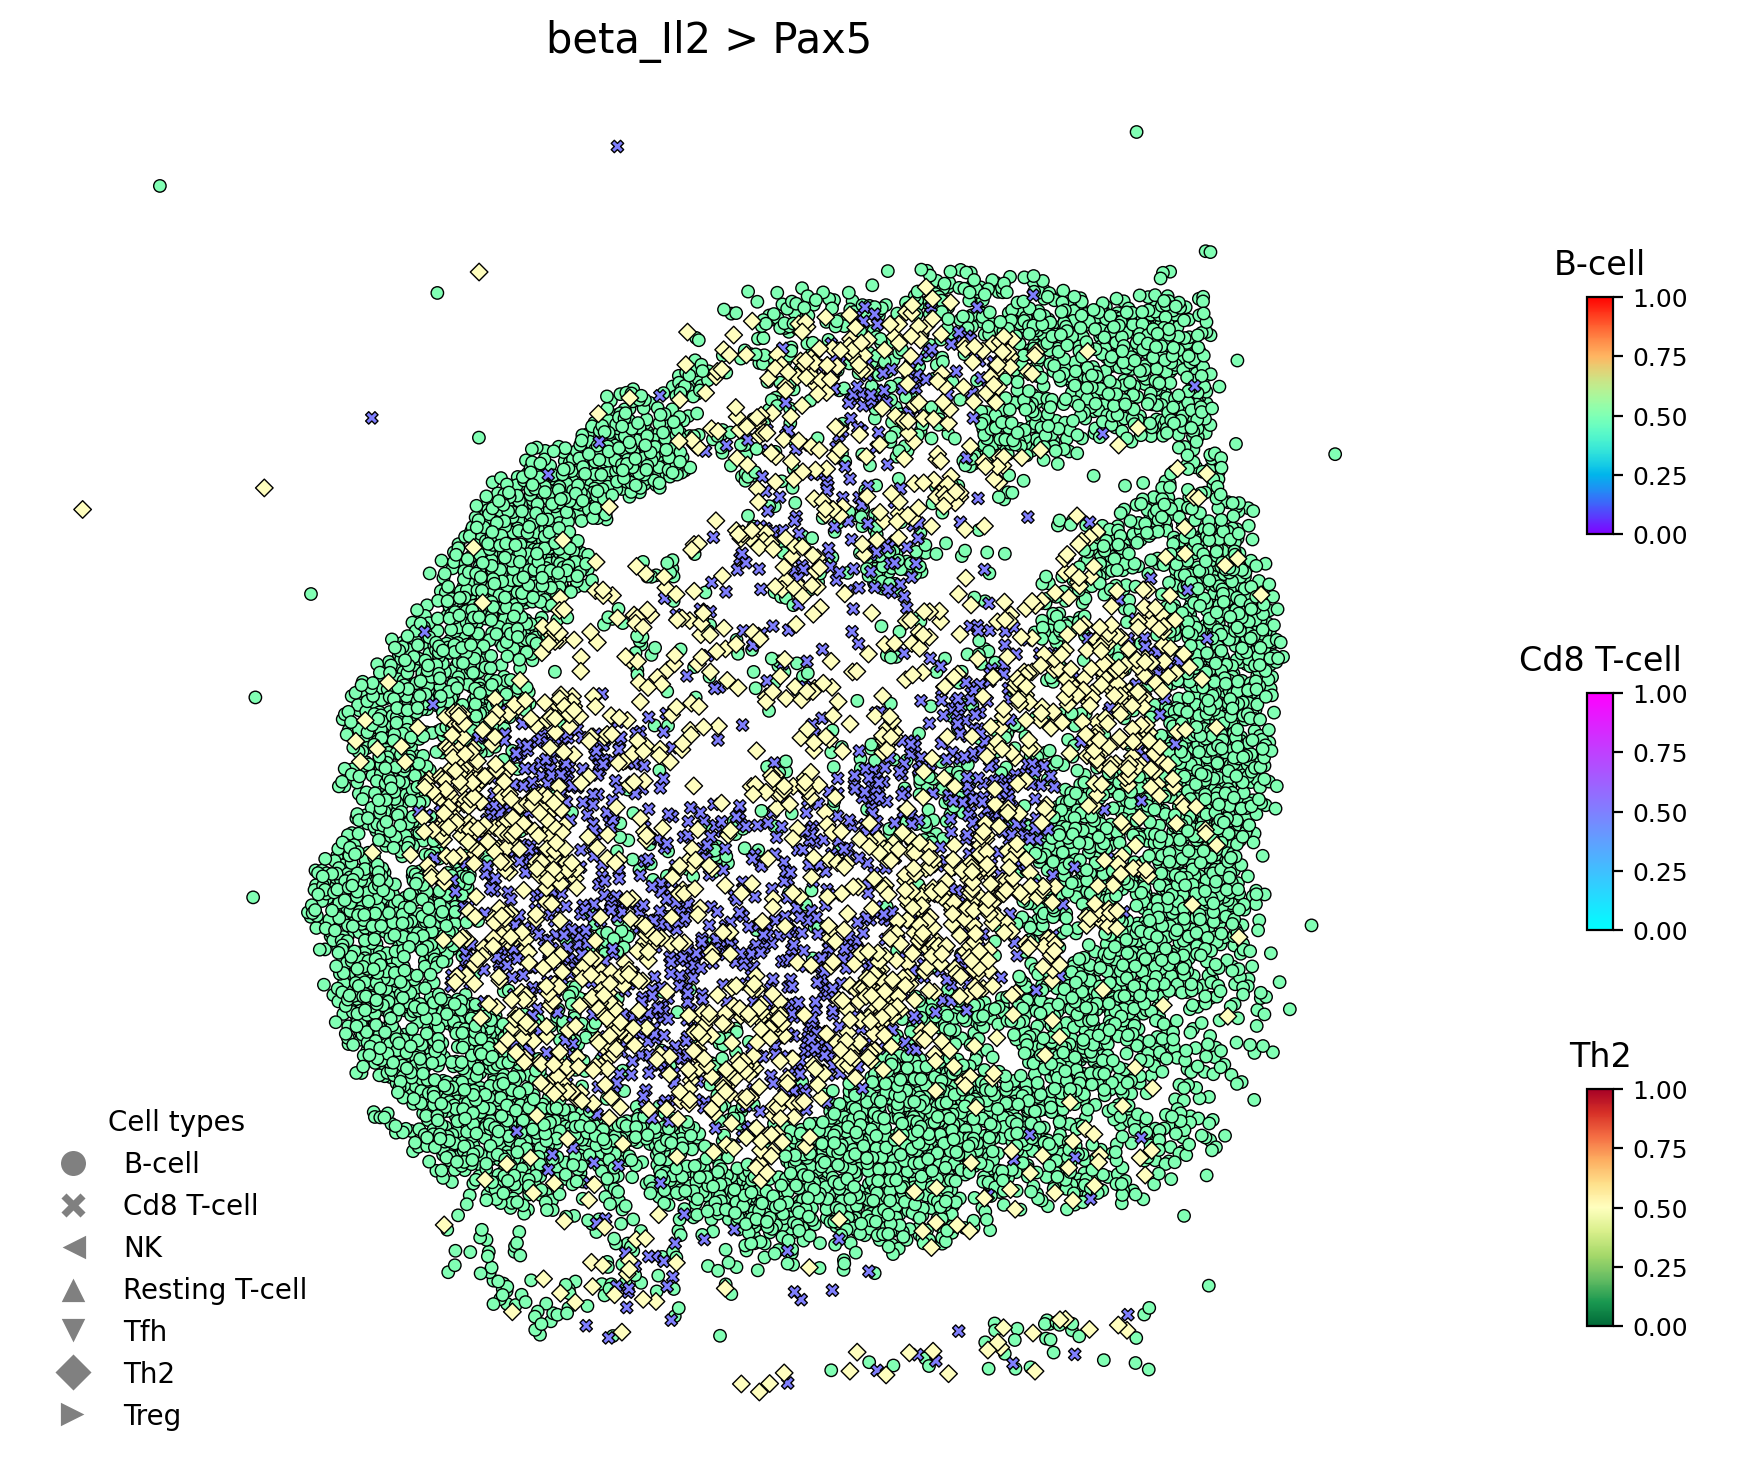

In [63]:
plot('beta_Il2', dpi=100, size=20)

In [ ]:
fig, axs = plt.subplots(1, 4, dpi=180, figsize=(12*2, 9*1), gridspec_kw={'width_ratios': [4, 0.5]*2})
axs = axs.flatten()
axs = [(axs[i], axs[i+1]) for i in range(0, len(axs), 2)]
plot('beta_Il2#Egr2', dpi=100, size=20, fig=fig, axes=axs[0])
plot('beta_Il2#Egr2', dpi=100, size=20, fig=fig, axes=axs[1], with_expr=True)
# plot('Egr2', dpi=100, size=20, fig=fig, axes=axs[2])
# plot('Il2', dpi=100, size=20, fig=fig, axes=axs[3])
# plot('beta_Egr2', dpi=100, size=20, fig=fig, axes=axs[4])
# plot('Il2#Egr2', dpi=100, size=20, fig=fig, axes=axs[5])
plt.show()
